In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras import backend
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from itertools import product as myzip

We import our data into a dictionary, the keys of which describe the splitting.

In [3]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [4]:
def format_fn(path):
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [5]:
for dataset in datasets:
    x_paths = glob.glob(my_path + dataset + '/*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '/*.png')
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    data_dict[dataset] = data_dict[dataset].shuffle(10**4, reshuffle_each_iteration=True)
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

Let's have a look at the labelled data.

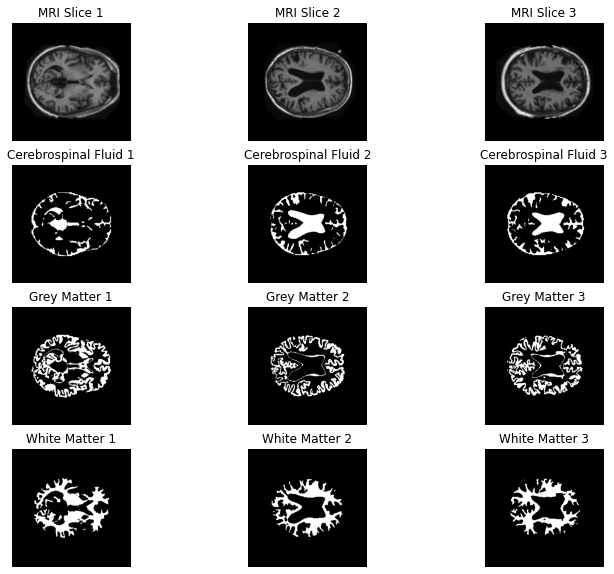

In [6]:
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
x_sample = tf.reshape(x_sample, [3, 256, 256])
y_sample = tf.reshape(y_sample, [3, 256, 256, 4])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

Next we build subclasses for the UNet layers we will need, ```Downshift``` for downsampling and ```Upshift``` for upsampling sections.

In [7]:
class My_Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel=3, dropout=.3):
        super(My_Conv2D, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, kernel, activation='relu', padding='same')
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        
    def call(self, x):
        x = self.conv2d_1(x)
        x = self.dropout_1(x)
        
        return x

class Downshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Downshift, self).__init__()
        self.conv2d_1 = My_Conv2D(filters)
        self.conv2d_2 = My_Conv2D(filters)
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(padding='same')
        
    def call(self, x):
        x = self.conv2d_1(x)
        x_res = self.conv2d_2(x)
        x = self.maxpool_1(x_res)
        
        return x, x_res
    
class Upshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Upshift, self).__init__()
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = My_Conv2D(filters)
        self.concatenate_1 = tf.keras.layers.Concatenate()
        self.conv2d_2 = My_Conv2D(filters)
        self.conv2d_3 = My_Conv2D(filters)
        
    def call(self, x, x_res):
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1([x_res, x])
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        
        return x

Here we will use the smoothed Jaccard distance (1 - IoU) as an objective function; we suppose that the smoothed Jaccard distance has the same optima as the Jaccard distance (similar to a log likelihood) but avoids the problem of vanishing/exploding gradients.

In [19]:
def smoothed_jaccard_distance(y_ground, y_predicted, smoothing=.1):
    intersection = backend.sum(y_ground*y_predicted, axis=(1, 2))
    union = backend.sum(y_ground + y_predicted, axis=(1, 2))
    jaccard_index = (intersection + smoothing)/(union - intersection + smoothing)
    
    return (1 - jaccard_index)*smoothing

Before building a larger model, we first test our concept on a smaller scale.

In [20]:
  class My_Simple_Model(tf.keras.Model):
    def __init__(self):
        super(My_Simple_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        
        self.downshift_1 = Downshift(40)
        self.upshift_1 = Upshift(40)
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='sigmoid', padding='same')
        
    def call(self, x_0, training=False):
        x_1 = self.input_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3 = self.upshift_1(x_2, x_2_res)
        
        x_4 = self.output_1(x_3)
        
        return x_4

In [13]:
simple_model = My_Simple_Model()

my_opt = adam(lr=10**-3)

simple_model.compile(optimizer=my_opt, 
              loss=smoothed_jaccard_distance,
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

simple_model.build(input_shape=(None, 256, 256, 1))

simple_model.summary()

Model: "my__simple__model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [None]                    0         
_________________________________________________________________
downshift_2 (Downshift)      multiple                  14840     
_________________________________________________________________
upshift_2 (Upshift)          multiple                  57720     
_________________________________________________________________
conv2d_17 (Conv2D)           multiple                  164       
Total params: 72,724
Trainable params: 72,724
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = simple_model.fit(data_dict['train'].batch(10), epochs=1,
                    validation_data=data_dict['validate'].batch(10), verbose=1)

Train for 967 steps, validate for 112 steps
967/967 [==============================] - 177s 183ms/step - loss: 0.1965 - mean_io_u_2: 0.7853 - val_loss: 0.1129 - val_mean_io_u_2: 0.8596


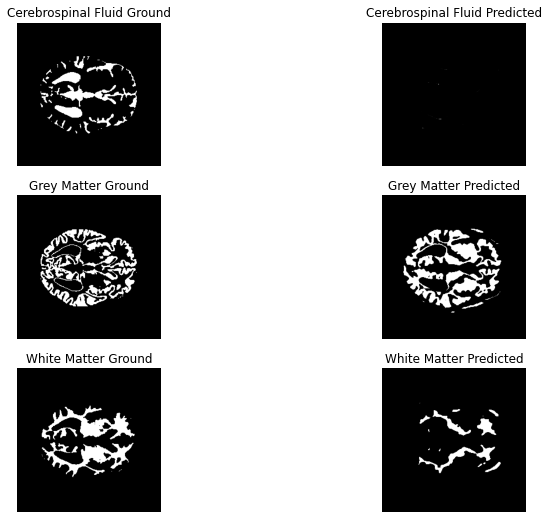

In [15]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = simple_model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

Not bad for a single epoch; onto the larger model.

In [15]:
class My_Larger_Model(tf.keras.Model):
    def __init__(self):
        super(My_Larger_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        
        self.downshift_1 = Downshift(64)
        self.downshift_2 = Downshift(128)
        self.downshift_3 = Downshift(256)
        
        self.deepconv2d_1 = My_Conv2D(512)
        self.deepconv2d_2 = My_Conv2D(512)
        
        self.upshift_1 = Upshift(256)
        self.upshift_2 = Upshift(128)
        self.upshift_3 = Upshift(64)
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='sigmoid', padding='same')
        
    def call(self, x_0):
        x_1 = self.input_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3, x_3_res = self.downshift_2(x_2)
        x_4, x_4_res = self.downshift_3(x_3)
        
        x_5 = self.deepconv2d_1(x_4)
        x_6 = self.deepconv2d_2(x_5)

        x_7 = self.upshift_1(x_6, x_4_res)
        x_8 = self.upshift_2(x_7, x_3_res)
        x_9 = self.upshift_3(x_8, x_2_res)

        x_10 = self.output_1(x_9)
        
        return x_10

In [20]:
larger_model = My_Larger_Model()

my_opt = adam(lr=3*10**-5)

larger_model.compile(optimizer=my_opt, 
              loss=smoothed_jaccard_distance,
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

larger_model.build(input_shape=(None, 256, 256, 1))

larger_model.summary()

Model: "my__larger__model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [None]                    0         
_________________________________________________________________
downshift_9 (Downshift)      multiple                  37568     
_________________________________________________________________
downshift_10 (Downshift)     multiple                  221440    
_________________________________________________________________
downshift_11 (Downshift)     multiple                  885248    
_________________________________________________________________
my__conv2d_57 (My_Conv2D)    multiple                  1180160   
_________________________________________________________________
my__conv2d_58 (My_Conv2D)    multiple                  2359808   
_________________________________________________________________
upshift_9 (Upshift)          multiple          

In [21]:
history = larger_model.fit(data_dict['train'].batch(10), epochs=3,
                    validation_data=data_dict['validate'].batch(10), verbose=1)

Train for 967 steps, validate for 112 steps
Epoch 1/3
967/967 [==============================] - 510s 527ms/step - loss: 0.0661 - mean_io_u_3: 0.3664 - val_loss: 0.0776 - val_mean_io_u_3: 0.3758
Epoch 2/3
967/967 [==============================] - 430s 445ms/step - loss: 0.0234 - mean_io_u_3: 0.8605 - val_loss: 0.0826 - val_mean_io_u_3: 0.3549
Epoch 3/3
967/967 [==============================] - 524s 542ms/step - loss: 0.0172 - mean_io_u_3: 0.9085 - val_loss: 0.0819 - val_mean_io_u_3: 0.3597


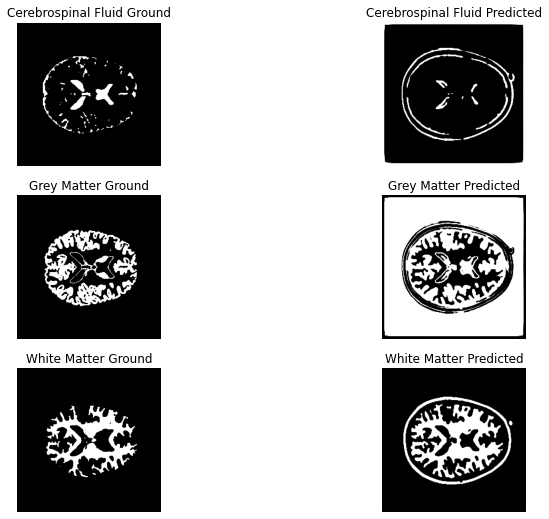

In [25]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = larger_model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

Observing serious overfitting problems as well as convergence issues with the smoothed Jaccard difference, we churn through more epochs to see if we can converge. After all, the model has attained useful features.

In [26]:
history = larger_model.fit(data_dict['train'].batch(10), epochs=5,
                    validation_data=data_dict['validate'].batch(10), verbose=1)

Train for 967 steps, validate for 112 steps
Epoch 1/5
967/967 [==============================] - 463s 478ms/step - loss: 0.0154 - mean_io_u_3: 0.9191 - val_loss: 0.0814 - val_mean_io_u_3: 0.3598
Epoch 2/5
967/967 [==============================] - 475s 491ms/step - loss: 0.0144 - mean_io_u_3: 0.9242 - val_loss: 0.0816 - val_mean_io_u_3: 0.3579
Epoch 3/5
967/967 [==============================] - 471s 487ms/step - loss: 0.0136 - mean_io_u_3: 0.9275 - val_loss: 0.0804 - val_mean_io_u_3: 0.3626
Epoch 4/5
967/967 [==============================] - 468s 484ms/step - loss: 0.0130 - mean_io_u_3: 0.9287 - val_loss: 0.0785 - val_mean_io_u_3: 0.3743
Epoch 5/5
967/967 [==============================] - 537s 555ms/step - loss: 0.0125 - mean_io_u_3: 0.9278 - val_loss: 0.0771 - val_mean_io_u_3: 0.3893


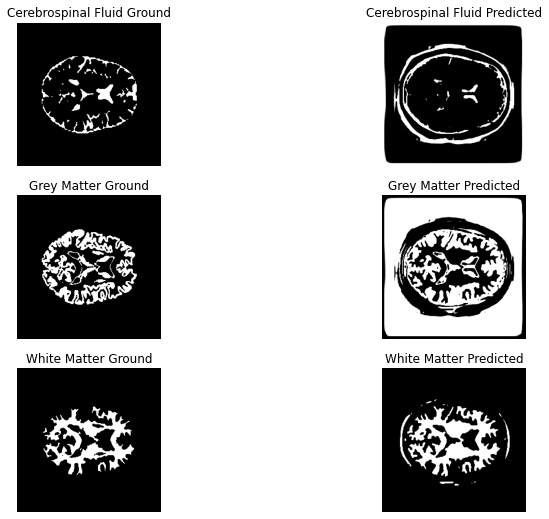

In [27]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = larger_model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

Things seem to be picking up, however we begin to suspect that some sort of hybrid loss function is required.

In [28]:
history = larger_model.fit(data_dict['train'].batch(10), epochs=5,
                    validation_data=data_dict['validate'].batch(10), verbose=1)

Train for 967 steps, validate for 112 steps
Epoch 1/5
967/967 [==============================] - 440s 455ms/step - loss: 0.0120 - mean_io_u_3: 0.9249 - val_loss: 0.0740 - val_mean_io_u_3: 0.4541
Epoch 2/5
967/967 [==============================] - 476s 493ms/step - loss: 0.0116 - mean_io_u_3: 0.9214 - val_loss: 0.0693 - val_mean_io_u_3: 0.4494
Epoch 3/5
967/967 [==============================] - 436s 451ms/step - loss: 0.0112 - mean_io_u_3: 0.9183 - val_loss: 0.0645 - val_mean_io_u_3: 0.4334
Epoch 4/5
967/967 [==============================] - 437s 452ms/step - loss: 0.0109 - mean_io_u_3: 0.9178 - val_loss: 0.0648 - val_mean_io_u_3: 0.4178
Epoch 5/5
967/967 [==============================] - 431s 445ms/step - loss: 0.0106 - mean_io_u_3: 0.9189 - val_loss: 0.0631 - val_mean_io_u_3: 0.3851


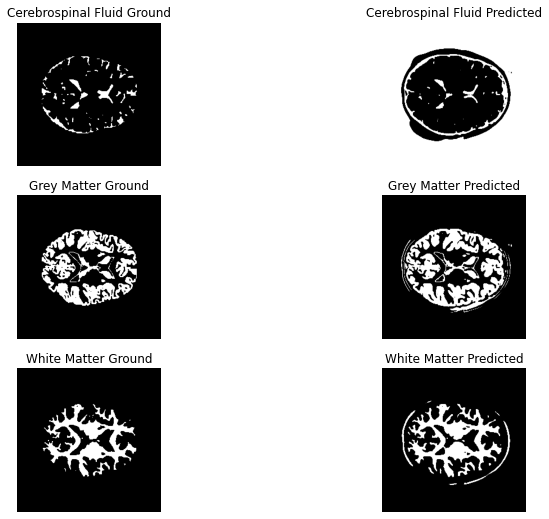

In [29]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = larger_model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()